## 1. Generation

### 1.1 Global configuation

In [1]:
import torch

device = "cuda"
torch.manual_seed(42)
torch.use_deterministic_algorithms(True, warn_only=True)

### 1.2 Load model

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)

### 1.3 Configure prediction

In [3]:
max_inference_length = 5
input_string = "Super Mario Land is a game that developed by"

### 1.4 Run prediction

In [4]:
input_ids = tokenizer(input_string, return_tensors='pt')['input_ids'][0].to(model.device)
generated_ids = model.generate(input_ids=torch.unsqueeze(input_ids, 0), max_length=(input_ids.shape[0] + max_inference_length), do_sample=False)[0]
generated_texts = [ tokenizer.decode(token) for token in generated_ids ]
print(f'generated full sequence --> {generated_texts}')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


generated full sequence --> ['Super', ' Mario', ' Land', ' is', ' a', ' game', ' that', ' developed', ' by', ' Nintendo', ',', ' and', ' was', ' released']


/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py:184: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:159.)
  attn_weights = torch.matmul(query, key.transpose(-1, -2))
/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py:219: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDete

## 2. Rationalization

### 2.1 Construct rationalizer

In [5]:
from rationalization.rationalizer.aggregate_rationalizer import AggregateRationalizer
from rationalization.rationalizer.importance_score_evaluator.delta_prob import DeltaProbImportanceScoreEvaluator
from rationalization.rationalizer.stopping_condition_evaluator.top_k import TopKStoppingConditionEvaluator
from rationalization.rationalizer.token_replacement.token_replacer.uniform import UniformTokenReplacer
from rationalization.rationalizer.token_replacement.token_sampler.postag import POSTagTokenSampler

rational_size = 5
rational_size_ratio = None

token_sampler = POSTagTokenSampler(tokenizer=tokenizer, device=device)

stopping_condition_evaluator = TopKStoppingConditionEvaluator(
    model=model, 
    token_sampler=token_sampler, 
    top_k=3, 
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio, 
    tokenizer=tokenizer
)

importance_score_evaluator = DeltaProbImportanceScoreEvaluator(
    model=model, 
    tokenizer=tokenizer, 
    token_replacer=UniformTokenReplacer(
        token_sampler=token_sampler, 
        ratio=0.3
    ),
    stopping_condition_evaluator=stopping_condition_evaluator,
    max_steps=3000
)

rationalizer = AggregateRationalizer(
    importance_score_evaluator=importance_score_evaluator,
    batch_size=8,
    overlap_threshold=2,
    overlap_strict_pos=True,
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio
)

[POSTagTokenSampler] Loading vocab from tokenizer - 0.00%
[POSTagTokenSampler] Loading vocab from tokenizer - 9.95%
[POSTagTokenSampler] Loading vocab from tokenizer - 19.90%
[POSTagTokenSampler] Loading vocab from tokenizer - 29.85%
[POSTagTokenSampler] Loading vocab from tokenizer - 39.80%
[POSTagTokenSampler] Loading vocab from tokenizer - 49.74%
[POSTagTokenSampler] Loading vocab from tokenizer - 59.69%
[POSTagTokenSampler] Loading vocab from tokenizer - 69.64%
[POSTagTokenSampler] Loading vocab from tokenizer - 79.59%
[POSTagTokenSampler] Loading vocab from tokenizer - 89.54%
[POSTagTokenSampler] Loading vocab from tokenizer - 99.49%


### 2.2 Run rationalization

In [6]:
# rationalize each generated token

importance_scores = []
importance_score_map = torch.zeros([generated_ids.shape[0] - input_ids.shape[0], generated_ids.shape[0] - 1], device=device)

for target_pos in torch.arange(input_ids.shape[0], generated_ids.shape[0]):
    
    # extract target
    target_id = generated_ids[target_pos]

    # rationalization
    pos_rational = rationalizer.rationalize(torch.unsqueeze(generated_ids[:target_pos], 0), torch.unsqueeze(target_id, 0))[0]

    ids_rational = generated_ids[pos_rational]
    text_rational = [ tokenizer.decode([id_rational]) for id_rational in ids_rational ]

    importance_score_map[target_pos - input_ids.shape[0], :target_pos] = rationalizer.mean_important_score

    print(f'{target_pos + 1} / {generated_ids.shape[0]}')
    print(f'Target word     --> {tokenizer.decode(target_id)}', )
    print(f"Rational pos    --> {pos_rational}")
    print(f"Rational text   --> {text_rational}")

    print()

/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py:184: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:159.)
  attn_weights = torch.matmul(query, key.transpose(-1, -2))
/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py:219: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDete

10 / 14
Target word     -->  Nintendo
Rational pos    --> tensor([0, 1, 2, 3, 4, 5, 6, 7, 8], device='cuda:0')
Rational text   --> ['Super', ' Mario', ' Land', ' is', ' a', ' game', ' that', ' developed', ' by']

11 / 14
Target word     --> ,
Rational pos    --> tensor([0, 1, 2, 3, 4, 5, 7, 8, 9], device='cuda:0')
Rational text   --> ['Super', ' Mario', ' Land', ' is', ' a', ' game', ' developed', ' by', ' Nintendo']

12 / 14
Target word     -->  and
Rational pos    --> tensor([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')
Rational text   --> ['Super', ' Land', ' is', ' a', ' game', ' that', ' developed', ' by', ' Nintendo', ',']

13 / 14
Target word     -->  was
Rational pos    --> tensor([ 0,  3,  4,  6,  7,  8,  9, 11], device='cuda:0')
Rational text   --> ['Super', ' is', ' a', ' that', ' developed', ' by', ' Nintendo', ' and']

14 / 14
Target word     -->  released
Rational pos    --> tensor([ 2,  3,  4,  5,  7,  8,  9, 11, 12], device='cuda:0')
Rational text   --> [' 

### 2.3 Visualize rationalization results

<AxesSubplot:xlabel='Importance distribution', ylabel='Target'>

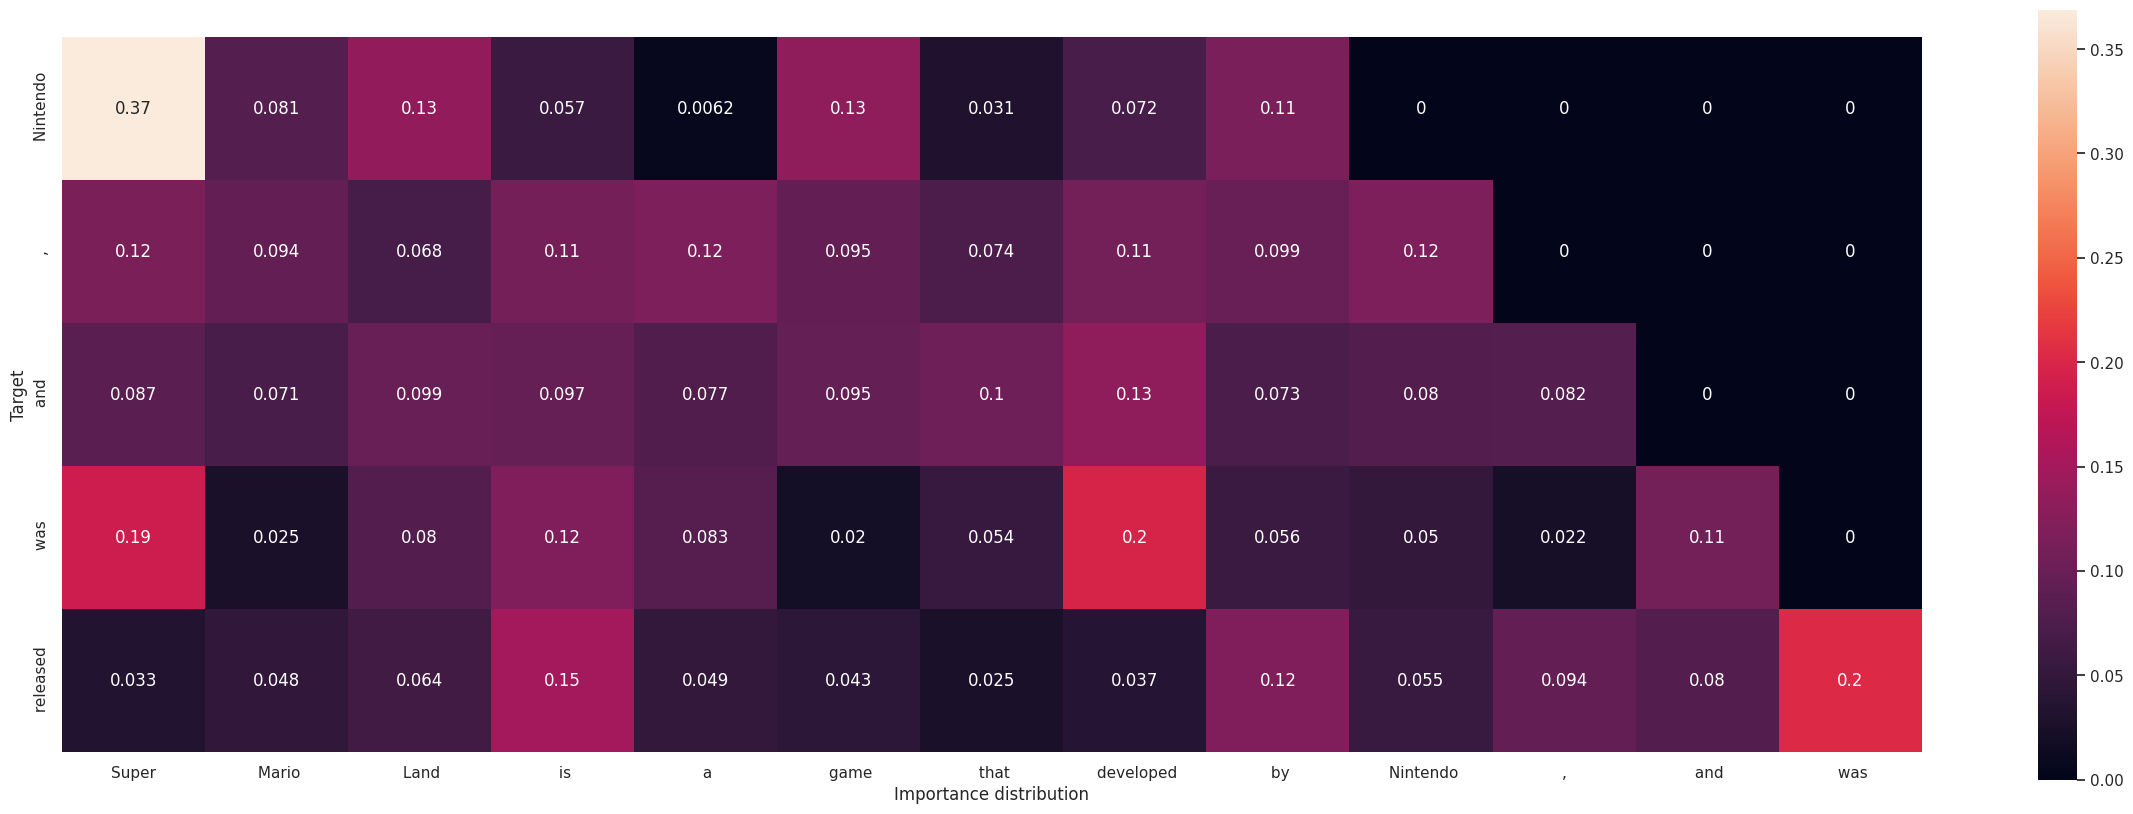

In [7]:
import seaborn
seaborn.set(rc={ 'figure.figsize': (30, 10) })
s = seaborn.heatmap(
    importance_score_map.cpu(), 
    xticklabels=generated_texts[:-1], 
    yticklabels=generated_texts[input_ids.shape[0]:], 
    annot=True, 
    square=True)
s.set_xlabel('Importance distribution')
s.set_ylabel('Target')
s

## 3. Evaluation

### 3.1 Configure evaluation

In [8]:
metric_stride = 1

### 3.2 Compute metrics

In [9]:
from evaluation.evaluator.soft_norm_sufficiency import SoftNormalizedSufficiencyEvaluator
from evaluation.evaluator.soft_norm_comprehensiveness import SoftNormalizedComprehensivenessEvaluator
soft_norm_suff_evaluator = SoftNormalizedSufficiencyEvaluator(model)
soft_norm_comp_evaluator = SoftNormalizedComprehensivenessEvaluator(model)

source_soft_ns_all = []
source_soft_nc_all = []
random_soft_ns_all = []
random_soft_nc_all = []
target_token_all = []

table_details = [ ["target_pos", "target_token", "source_soft_ns", "source_soft_nc", "rand_soft_ns", "rand_soft_nc"] ]

for target_pos in torch.arange(input_ids.shape[0], generated_ids.shape[0], metric_stride):

    target_token = tokenizer.decode(generated_ids[target_pos])
    target_token_all.append(target_token)

    input_ids_step = torch.unsqueeze(generated_ids[:target_pos], 0)
    target_id_step = torch.unsqueeze(generated_ids[target_pos], 0)
    importance_score_step = torch.unsqueeze(importance_score_map[target_pos - input_ids.shape[0], :target_pos], 0)
    random_importance_score_step = torch.softmax(torch.rand(importance_score_step.shape, device=device), dim=-1)

    # compute Soft-NS and Soft-NC on source importance score

    source_soft_ns_step = soft_norm_suff_evaluator.evaluate(input_ids_step, target_id_step, importance_score_step)
    source_soft_ns_all.append(source_soft_ns_step)

    source_soft_nc_step = soft_norm_comp_evaluator.evaluate(input_ids_step, target_id_step, importance_score_step)
    source_soft_nc_all.append(source_soft_nc_step)

    # compute Soft-NS and Soft-NC on random importance score

    random_soft_ns_step = soft_norm_suff_evaluator.evaluate(input_ids_step, target_id_step, random_importance_score_step)
    random_soft_ns_all.append(random_soft_ns_step)

    random_soft_nc_step = soft_norm_comp_evaluator.evaluate(input_ids_step, target_id_step, random_importance_score_step)
    random_soft_nc_all.append(random_soft_nc_step)

    table_details.append([
        target_pos.item() + 1, target_token, 
        f"{source_soft_ns_step.item():.3f}", f"{source_soft_nc_step.item():.3f}", 
        f"{random_soft_ns_step.item():.3f}", f"{random_soft_nc_step.item():.3f}", 
        # metric_soft_ns_step.item(), metric_soft_nc_step.item()
        ])
    print(f"target_pos: {target_pos + 1}, target_token: {target_token}, Source Soft-NS: {source_soft_ns_step}, Source Soft-NC: {source_soft_nc_step}, Random Soft-NS: {random_soft_ns_step}, Random Soft-NC: {random_soft_nc_step}")

# compute metrics on Soft-NS and Soft-NC

metric_soft_ns = torch.log(torch.sum(torch.tensor(source_soft_ns_all, device=device)) / torch.sum(torch.tensor(random_soft_ns_all, device=device)))
metric_soft_nc = torch.log(torch.sum(torch.tensor(source_soft_nc_all, device=device)) / torch.sum(torch.tensor(random_soft_nc_all, device=device)))

print(f"metric_soft_ns: {metric_soft_ns}, metric_soft_nc: {metric_soft_nc}")

/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py:184: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility (Triggered internally at ../aten/src/ATen/Context.cpp:159.)
  attn_weights = torch.matmul(query, key.transpose(-1, -2))
/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/transformers/models/gpt2/modeling_gpt2.py:219: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDete

target_pos: 10, target_token:  Nintendo, Source Soft-NS: 0.0, Source Soft-NC: 0.004445562604814768, Random Soft-NS: 0.0, Random Soft-NC: 0.019402140751481056
target_pos: 11, target_token: ,, Source Soft-NS: 0.2553461790084839, Source Soft-NC: 0.01696317456662655, Random Soft-NS: 0.0, Random Soft-NC: 0.006987605709582567
target_pos: 12, target_token:  and, Source Soft-NS: 0.0, Source Soft-NC: 0.005914425477385521, Random Soft-NS: 0.003942588809877634, Random Soft-NC: 0.017186634242534637
target_pos: 13, target_token:  was, Source Soft-NS: 0.007712581194937229, Source Soft-NC: 0.0076824272982776165, Random Soft-NS: 0.0, Random Soft-NC: 0.005903724115341902
target_pos: 14, target_token:  released, Source Soft-NS: 0.02735670655965805, Source Soft-NC: 0.004680009093135595, Random Soft-NS: 0.0, Random Soft-NC: 0.004598025698214769
metric_soft_ns: 4.299475193023682, metric_soft_nc: -0.30944153666496277


### 3.3 Show metrics in tables

In [10]:
import tabulate
from IPython.display import HTML, display

table_details_html = tabulate.tabulate(table_details, tablefmt='html')

display(HTML(table_details_html))

table_mean = [
        [ "target_tokens", "metric_soft_ns", "metric_soft_nc" ],
        [ "$".join(target_token_all), f"{metric_soft_ns.item():.3f}", f"{metric_soft_nc.item():.3f}" ]
    ]

table_mean_html = tabulate.tabulate(table_mean, tablefmt='html')

display(HTML(table_mean_html))

target_pos,target_token,source_soft_ns,source_soft_nc,rand_soft_ns,rand_soft_nc
10,Nintendo,0.000,0.004,0.000,0.019
11,",",0.255,0.017,0.000,0.007
12,and,0.000,0.006,0.004,0.017
13,was,0.008,0.008,0.000,0.006
14,released,0.027,0.005,0.000,0.005


target_tokens,metric_soft_ns,metric_soft_nc
"Nintendo$,$ and$ was$ released",4.299,-0.309


### 3.4 Save results to file

In [11]:
import csv

with open('notebook_details.csv', 'w', newline='') as csvfile:
    csvWriter = csv.writer(csvfile)
    csvWriter.writerows(table_details)

with open('notebook_mean.csv', 'w', newline='') as csvfile:
    csvWriter = csv.writer(csvfile)
    csvWriter.writerows(table_mean)